In [73]:
import pandas as pd
import urllib
from urllib.request import urlretrieve

In [74]:
post = pd.read_csv("../data/raw/postcode_info.csv")
df = pd.DataFrame()

In [75]:
rent_data = pd.read_excel("https://www.dffh.vic.gov.au/sites/default/files/documents/202209/Moving%20annual%20rent%20by%20suburb%20-%20June%20quarter%202022.xlsx", sheet_name='All properties')
rent = rent_data.drop(index= list(rent_data[rent_data['Unnamed: 1'] == 'Group Total'].index))
rent_data = rent_data.loc[2:]
rent_data.drop(['Moving annual median rent by suburb'],axis=1,inplace=True)
rent_data = rent_data.loc[:,::2]
rent_data.rename(columns={'Unnamed: 1':'suburb'}, inplace = True)
rent_data.head()

,suburb,Unnamed: 3,Unnamed: 5,Unnamed: 7,Unnamed: 9,Unnamed: 11,Unnamed: 13,Unnamed: 15,Unnamed: 17,Unnamed: 19,...,Unnamed: 163,Unnamed: 165,Unnamed: 167,Unnamed: 169,Unnamed: 171,Unnamed: 173,Unnamed: 175,Unnamed: 177,Unnamed: 179,Unnamed: 181
2,Albert Park-Middle Park-West St Kilda,260,260,270,275,275,280,280,290,300,...,600,580,550,550,500,500,500,495,500,520
3,Armadale,200,200,205,210,215,220,225,230,233,...,500,500,500,495,450,440,425,420,430,450
4,Carlton North,260,260,265,270,270,275,280,280,290,...,585,590,590,590,580,575,575,580,580,595
5,Carlton-Parkville,260,260,260,260,260,260,265,270,270,...,404,400,400,395,350,340,330,320,310,319
6,CBD-St Kilda Rd,320,320,320,320,320,320,320,320,320,...,510,495,460,420,380,369,350,350,364,390


In [76]:
#Preprocess suburb
import operator
data_suburb = pd.DataFrame()
sublist = []
for i in rent_data["suburb"]:
    index = rent_data[rent_data.suburb == i].index.tolist()[0]
    if operator.contains(i, "-"):
        j = i.split("-")
        for sub in j:
            sublist.append(sub)
            series = pd.DataFrame(rent_data[index-2:index-1])
            data_suburb = pd.concat([data_suburb, series])
    else:
        sublist.append(i)
        series = pd.DataFrame(rent_data[index-2:index-1])
        data_suburb = pd.concat([data_suburb, series])

data_suburb.insert(0, "suburb new", sublist)
data_suburb.drop(data_suburb.columns[1:2],axis=1,inplace=True)
name = ['suburb']
for i in list(range(2,181,2)):
    name.append(rent[rent.columns.values.tolist()[i]][:1].tolist()[0])
data_suburb.columns = name
data_suburb['postcode'] = ''
df = data_suburb.reset_index(drop=True)

In [77]:
df

,suburb,Mar 2000,Jun 2000,Sep 2000,Dec 2000,Mar 2001,Jun 2001,Sep 2001,Dec 2001,Mar 2002,...,Jun 2020,Sep 2020,Dec 2020,Mar 2021,Jun 2021,Sep 2021,Dec 2021,Mar 2022,Jun 2022,postcode
0,Albert Park,260,260,270,275,275,280,280,290,300,...,580,550,550,500,500,500,495,500,520,
1,Middle Park,260,260,270,275,275,280,280,290,300,...,580,550,550,500,500,500,495,500,520,
2,West St Kilda,260,260,270,275,275,280,280,290,300,...,580,550,550,500,500,500,495,500,520,
3,Armadale,200,200,205,210,215,220,225,230,233,...,500,500,495,450,440,425,420,430,450,
4,Carlton North,260,260,265,270,270,275,280,280,290,...,590,590,590,580,575,575,580,580,595,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Wanagaratta,125,125,130,130,130,130,130,135,135,...,300,300,308,320,330,350,360,370,380,
224,Warragul,130,135,135,135,135,135,140,140,150,...,350,360,380,375,380,390,390,400,400,
225,Warrnambool,130,135,135,135,140,140,140,145,145,...,340,340,350,350,360,370,380,400,400,
226,Wodonga,145,145,150,150,150,150,150,150,150,...,330,330,330,340,350,360,370,380,390,


In [78]:
df[df['suburb'] == 'Group Total'].index

Int64Index([32, 62, 82, 100, 121, 143, 154, 165, 176, 187, 195, 202, 227], dtype='int64')

In [79]:
for i in range(len(df)):
    if post[(post['Locality'] == str.upper(df['suburb'][i]))]['Postcode'].to_list() == []:
        df.loc[i,'postcode'] = 0
    else:
        df.loc[i,'postcode'] = post[(post['Locality'] == str.upper(df['suburb'][i])) & (post['State'] == 'VIC')]['Postcode'].to_list()[0]
df=df.drop(df[df['suburb'] == 'Group Total'].index)


In [80]:
#check which suburb cannot be Identified
df[df['postcode'] == 0]

,suburb,Mar 2000,Jun 2000,Sep 2000,Dec 2000,Mar 2001,Jun 2001,Sep 2001,Dec 2001,Mar 2002,...,Jun 2020,Sep 2020,Dec 2020,Mar 2021,Jun 2021,Sep 2021,Dec 2021,Mar 2022,Jun 2022,postcode
2,West St Kilda,260,260,270,275,275,280,280,290,300,...,580,550,550,500,500,500,495,500,520,0
7,CBD,320,320,320,320,320,320,320,320,320,...,495,460,420,380,369,350,350,364,390,0
8,St Kilda Rd,320,320,320,320,320,320,320,320,320,...,495,460,420,380,369,350,350,364,390,0
13,East St Kilda,180,180,180,180,185,190,195,195,200,...,425,420,410,395,385,380,380,380,390,0
51,East Hawthorn,200,201,210,215,220,230,235,235,230,...,440,438,420,400,400,390,380,390,400,0
107,East Brunswick,190,210,210,230,230,240,240,240,250,...,450,450,425,420,410,400,400,400,420,0
120,West Brunswick,140,141,145,150,150,153,160,165,170,...,400,390,380,380,360,350,350,350,360,0
153,Yarra Ranges,150,150,155,155,160,160,165,165,165,...,400,400,400,400,415,420,425,435,450,0
171,Mt Eliza,170,175,180,180,185,190,190,195,200,...,485,496,508,520,545,550,570,590,600,0
173,Mt Martha,170,175,180,180,185,190,190,195,200,...,485,496,508,520,545,550,570,590,600,0


In [81]:
df.loc[2,'postcode'] = 3182
df.loc[7,'postcode'] = 3000
df.loc[8,'postcode'] = 3004
df.loc[13,'postcode'] = 3183
df.loc[51,'postcode'] = 3123
df.loc[107,'postcode'] = 3057
df.loc[120,'postcode'] = 3055
df.loc[153,'postcode'] = 3160
df.loc[171,'postcode'] = 3930
df.loc[173,'postcode'] = 3934
df.loc[181,'postcode'] = 3219
df.loc[198,'postcode'] = 3550
df.loc[223,'postcode'] = 3677

In [82]:
df2 = df.drop(df.columns[1:57], axis=1)
df2

,suburb,Mar 2014,Jun 2014,Sep 2014,Dec 2014,Mar 2015,Jun 2015,Sep 2015,Dec 2015,Mar 2016,...,Jun 2020,Sep 2020,Dec 2020,Mar 2021,Jun 2021,Sep 2021,Dec 2021,Mar 2022,Jun 2022,postcode
0,Albert Park,460,470,480,480,480,495,495,500,520,...,580,550,550,500,500,500,495,500,520,3206
1,Middle Park,460,470,480,480,480,495,495,500,520,...,580,550,550,500,500,500,495,500,520,3206
2,West St Kilda,460,470,480,480,480,495,495,500,520,...,580,550,550,500,500,500,495,500,520,3182
3,Armadale,390,395,390,400,400,399,400,400,400,...,500,500,495,450,440,425,420,430,450,3143
4,Carlton North,510,510,520,520,530,530,530,530,530,...,590,590,590,580,575,575,580,580,595,3054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Traralgon,260,260,265,270,270,270,270,270,270,...,300,310,320,330,340,350,360,360,380,3844
223,Wanagaratta,240,250,250,250,250,250,250,250,260,...,300,300,308,320,330,350,360,370,380,3677
224,Warragul,270,270,271,280,280,280,280,280,290,...,350,360,380,375,380,390,390,400,400,3820
225,Warrnambool,280,280,280,280,280,280,290,290,290,...,340,340,350,350,360,370,380,400,400,3280


In [83]:
for i in range(1, len(df2.columns)-2, 4):
    df2[df2.columns[i][-4:]] = df2[[df2.columns[i], df2.columns[i+1], df2.columns[i+2], df2.columns[i+3]]].mean(axis=1)
    if i  == 33:
        df2[df2.columns[i][-4:]] = df2[[df2.columns[i], df2.columns[i+1]]].mean(axis=1)
df2

,suburb,Mar 2014,Jun 2014,Sep 2014,Dec 2014,Mar 2015,Jun 2015,Sep 2015,Dec 2015,Mar 2016,...,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Albert Park,460,470,480,480,480,495,495,500,520,...,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0
1,Middle Park,460,470,480,480,480,495,495,500,520,...,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0
2,West St Kilda,460,470,480,480,480,495,495,500,520,...,3182,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0
3,Armadale,390,395,390,400,400,399,400,400,400,...,3143,393.75,399.75,402.50,445.00,487.50,481.25,498.75,433.75,440.0
4,Carlton North,510,510,520,520,530,530,530,530,530,...,3054,515.00,530.00,527.50,545.00,566.25,579.25,588.75,577.50,587.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Traralgon,260,260,265,270,270,270,270,270,270,...,3844,263.75,270.00,270.00,276.25,278.75,287.50,307.50,345.00,370.0
223,Wanagaratta,240,250,250,250,250,250,250,250,260,...,3677,247.50,250.00,260.00,266.25,274.25,287.50,299.50,340.00,375.0
224,Warragul,270,270,271,280,280,280,280,280,290,...,3820,272.75,280.00,293.75,305.00,323.75,347.00,360.00,383.75,400.0
225,Warrnambool,280,280,280,280,280,280,290,290,290,...,3280,280.00,285.00,288.75,290.00,300.00,322.50,342.50,365.00,400.0


In [84]:
df3 = df2.drop(df2.columns[:35], axis=1)
df3

,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0
1,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0
2,3182,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0
3,3143,393.75,399.75,402.50,445.00,487.50,481.25,498.75,433.75,440.0
4,3054,515.00,530.00,527.50,545.00,566.25,579.25,588.75,577.50,587.5
...,...,...,...,...,...,...,...,...,...,...
222,3844,263.75,270.00,270.00,276.25,278.75,287.50,307.50,345.00,370.0
223,3677,247.50,250.00,260.00,266.25,274.25,287.50,299.50,340.00,375.0
224,3820,272.75,280.00,293.75,305.00,323.75,347.00,360.00,383.75,400.0
225,3280,280.00,285.00,288.75,290.00,300.00,322.50,342.50,365.00,400.0


In [14]:
pop = pd.read_csv("../data/raw/population_postcode.csv", index_col=0)
income = pd.read_csv("../data/raw/VIC_yearly_income_poa.csv", index_col=0)
pop

,Postcode,Longitude,Latitude,SA2 name,S/T name,2001,2002,2003,2004,2005,...,population density 2021(persons/km2),average change %,2022,2023,2024,2025,population density 2022,population density 2023,population density 2024,population density 2025
0,3002,144.982207,-37.818517,East Melbourne,Victoria,3731,3859,4243,4460,4495,...,1711.2,1.014927,5036.0,5111.0,5187.0,5264.0,1737.0,1762.0,1789.0,1815.0
1,3005,144.950858,-37.824608,Docklands,Victoria,154,926,1913,3089,3779,...,6522.9,1.422278,22674.0,32249.0,45867.0,65236.0,9448.0,13437.0,19111.0,27182.0
2,3008,144.948039,-37.814719,Docklands,Victoria,154,926,1913,3089,3779,...,6522.9,1.422278,22674.0,32249.0,45867.0,65236.0,9448.0,13437.0,19111.0,27182.0
3,3010,144.961351,-37.796152,Parkville,Victoria,5332,5327,5253,5201,5157,...,1838.9,1.017541,7577.0,7710.0,7845.0,7983.0,1894.0,1928.0,1961.0,1996.0
4,3050,144.954581,-37.800324,Parkville,Victoria,5332,5327,5253,5201,5157,...,1838.9,1.017541,7577.0,7710.0,7845.0,7983.0,1894.0,1928.0,1961.0,1996.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,3990,145.501279,-38.455399,Wonthaggi - Inverloch,Victoria,17647,17801,17956,18117,18250,...,36.7,1.021019,27285.0,27859.0,28445.0,29043.0,37.0,38.0,39.0,40.0
588,3991,145.466781,-38.483041,Wonthaggi - Inverloch,Victoria,17647,17801,17956,18117,18250,...,36.7,1.021019,27285.0,27859.0,28445.0,29043.0,37.0,38.0,39.0,40.0
589,3992,145.534315,-38.569135,Wonthaggi - Inverloch,Victoria,17647,17801,17956,18117,18250,...,36.7,1.021019,27285.0,27859.0,28445.0,29043.0,37.0,38.0,39.0,40.0
590,3995,145.630713,-38.578071,Wonthaggi - Inverloch,Victoria,17647,17801,17956,18117,18250,...,36.7,1.021019,27285.0,27859.0,28445.0,29043.0,37.0,38.0,39.0,40.0


In [15]:
income2 = income.drop(list(income.columns)[1:4],axis=1)
income2 = income2.drop(list(income.columns)[13:],axis=1)
income2 = income2.rename(columns={'Postcode':'postcode'})
income2

,postcode,Median income in 2014-15,Median income in 2015-16,Median income in 2016-17,Median income in 2017-18,Median income in 2018-19,Median income in 2019-2020,Median income in 2020-2021,Median income in 2021-2022,Median income in 2022-2023
0,3000,32697,31242,28068,28806,30024,29442.15,28871.58,28312.07,27763.40
1,8001,32697,31242,28068,28806,30024,29442.15,28871.58,28312.07,27763.40
2,8003,32697,31242,28068,28806,30024,29442.15,28871.58,28312.07,27763.40
3,8006,32697,31242,28068,28806,30024,29442.15,28871.58,28312.07,27763.40
4,8009,32697,31242,28068,28806,30024,29442.15,28871.58,28312.07,27763.40
...,...,...,...,...,...,...,...,...,...,...
691,3990,36316,36159,36496,38060,39884,40838.97,41816.81,42818.06,43843.29
692,3991,36316,36159,36496,38060,39884,40838.97,41816.81,42818.06,43843.29
693,3992,36316,36159,36496,38060,39884,40838.97,41816.81,42818.06,43843.29
694,3995,36316,36159,36496,38060,39884,40838.97,41816.81,42818.06,43843.29


In [16]:
result = pd.merge(df3, income2, how='left', on=['postcode'])
result

,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022,Median income in 2014-15,Median income in 2015-16,Median income in 2016-17,Median income in 2017-18,Median income in 2018-19,Median income in 2019-2020,Median income in 2020-2021,Median income in 2021-2022,Median income in 2022-2023
0,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,64975,67627,66160.0,66627.0,67518.0,68185.66,68859.93,69540.86,70228.53
1,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,64975,67627,66160.0,66627.0,67518.0,68185.66,68859.93,69540.86,70228.53
2,3182,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,52654,53562,53066.0,56940.0,59622.0,61531.25,63501.63,65535.11,67633.71
3,3143,393.75,399.75,402.50,445.00,487.50,481.25,498.75,433.75,440.0,62089,64169,64075.0,66098.0,69563.0,71580.85,73657.23,75793.84,77992.43
4,3054,515.00,530.00,527.50,545.00,566.25,579.25,588.75,577.50,587.5,53685,54412,54876.0,57240.0,60116.0,61850.24,63634.51,65470.25,67358.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,3844,263.75,270.00,270.00,276.25,278.75,287.50,307.50,345.00,370.0,37337,36367,35388.0,38003.0,37232.0,37238.59,37245.18,37251.77,37258.36
211,3677,247.50,250.00,260.00,266.25,274.25,287.50,299.50,340.00,375.0,41677,42880,43972.0,45587.0,47525.0,49111.99,50751.98,52446.73,54198.07
212,3820,272.75,280.00,293.75,305.00,323.75,347.00,360.00,383.75,400.0,42350,42680,43418.0,45069.0,47709.0,49160.38,50655.92,52196.95,53784.86
213,3280,280.00,285.00,288.75,290.00,300.00,322.50,342.50,365.00,400.0,42635,43536,44772.0,46945.0,48855.0,50549.58,52302.94,54117.12,55994.22


In [17]:
pop2 = pop.drop(list(pop.columns)[1:5],axis=1)
pop2 = pop2.drop(list(pop2.columns)[1:14],axis=1)
pop2 = pop2.drop(list(pop2.columns)[9:14],axis=1)
pop2 = pop2.drop(list(pop2.columns)[10:],axis=1)
pop2 = pop2.rename(columns={'Postcode':'postcode'})
for i in range(1,len(pop2.columns)):
    pop2 = pop2.rename(columns={pop2.columns[i]: 'pop' + pop2.columns[i]})
pop2

,postcode,pop2014,pop2015,pop2016,pop2017,pop2018,pop2019,pop2020,pop2021,pop2022
0,3002,5374,5411,5475,5495,5409,5413,5378,4962,5036.0
1,3005,9170,10444,11832,13923,15439,16375,16678,15942,22674.0
2,3008,9170,10444,11832,13923,15439,16375,16678,15942,22674.0
3,3010,7447,7682,7898,8182,8243,8294,8321,7446,7577.0
4,3050,7447,7682,7898,8182,8243,8294,8321,7446,7577.0
...,...,...,...,...,...,...,...,...,...,...
587,3990,21611,22039,22577,23270,23966,24739,25631,26723,27285.0
588,3991,21611,22039,22577,23270,23966,24739,25631,26723,27285.0
589,3992,21611,22039,22577,23270,23966,24739,25631,26723,27285.0
590,3995,21611,22039,22577,23270,23966,24739,25631,26723,27285.0


In [18]:
merge = pd.merge(result, pop2, how='left', on=['postcode'])
print(merge[merge.isnull().T.any()])
merge = merge.dropna().astype(float)
merge

    postcode    2014    2015    2016    2017    2018    2019    2020    2021  \
2       3182  472.50  492.50  515.00  527.75  562.50  569.25  570.00  498.75   
7       3000  435.00  441.25  452.50  480.00  493.75  505.00  471.25  362.25   
8       3004  435.00  441.25  452.50  480.00  493.75  505.00  471.25  362.25   
16      3068  495.00  500.00  501.25  525.00  550.00  565.00  552.50  535.00   
17      3068  495.00  500.00  501.25  525.00  550.00  565.00  552.50  535.00   
21      3003  395.00  397.50  403.75  422.50  445.00  450.00  446.25  373.75   
25      3121  473.75  477.50  487.50  503.75  516.25  525.00  518.75  465.00   
26      3121  473.75  477.50  487.50  503.75  516.25  525.00  518.75  465.00   
28      3141  405.00  420.00  441.25  450.00  467.00  484.00  461.25  405.00   
29      3006  506.25  521.25  533.75  540.00  541.25  553.75  494.00  400.00   
30      3182  379.00  380.00  396.25  407.50  420.00  428.75  420.00  378.75   
31      3142  451.25  451.25  464.00  48

,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022,...,Median income in 2022-2023,pop2014,pop2015,pop2016,pop2017,pop2018,pop2019,pop2020,pop2021,pop2022
0,3206.0,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,...,70228.53,15592.0,16053.0,16490.0,16495.0,16720.0,17071.0,16942.0,16023.0,16234.0
1,3206.0,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,...,70228.53,15592.0,16053.0,16490.0,16495.0,16720.0,17071.0,16942.0,16023.0,16234.0
3,3143.0,393.75,399.75,402.50,445.00,487.50,481.25,498.75,433.75,440.0,...,77992.43,9387.0,9485.0,9619.0,9632.0,9899.0,10036.0,10063.0,9436.0,9479.0
4,3054.0,515.00,530.00,527.50,545.00,566.25,579.25,588.75,577.50,587.5,...,67358.95,8893.0,8964.0,9058.0,9023.0,9020.0,8988.0,8891.0,8295.0,8289.0
5,3053.0,351.75,365.50,373.25,398.00,417.00,431.25,399.75,335.00,314.5,...,38245.23,17843.0,18983.0,20242.0,20669.0,20869.0,21088.0,20943.0,17198.0,17740.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,3844.0,263.75,270.00,270.00,276.25,278.75,287.50,307.50,345.00,370.0,...,37258.36,5349.0,5351.0,5371.0,5401.0,5433.0,5469.0,5538.0,5556.0,5550.0
211,3677.0,247.50,250.00,260.00,266.25,274.25,287.50,299.50,340.00,375.0,...,54198.07,18437.0,18624.0,18940.0,19183.0,19453.0,19600.0,19683.0,19877.0,20027.0
212,3820.0,272.75,280.00,293.75,305.00,323.75,347.00,360.00,383.75,400.0,...,53784.86,18004.0,18466.0,19088.0,19753.0,20478.0,21251.0,22055.0,23080.0,23648.0
213,3280.0,280.00,285.00,288.75,290.00,300.00,322.50,342.50,365.00,400.0,...,55994.22,20930.0,21217.0,21442.0,21676.0,21934.0,22157.0,22379.0,22462.0,22774.0


In [19]:
merge[merge['postcode'] == 3000.0]

,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022,...,Median income in 2022-2023,pop2014,pop2015,pop2016,pop2017,pop2018,pop2019,pop2020,pop2021,pop2022


In [20]:
len(list(merge[merge.columns[9]]))

166

In [21]:
rent_da = []
income_da = []
pop_da = []
for i in range(1,10):
    rent_da.append(list(merge[merge.columns[i]]))
for j in range(10,19):
    income_da.append(list(merge[merge.columns[j]]))
for k in range(19,28):
    pop_da.append(list(merge[merge.columns[k]]))
rent_da =[float(x) for item in rent_da for x in item]
income_da =[float(x) for item in income_da for x in item]
pop_da =[float(x) for item in pop_da for x in item]


In [22]:
data = {'rent': rent_da, 'income':income_da, 'population': pop_da}
dataset = pd.DataFrame(data)

In [23]:
dataset

,rent,income,population
0,472.50,64975.00,15592.0
1,472.50,64975.00,15592.0
2,393.75,62089.00,9387.0
3,515.00,53685.00,8893.0
4,351.75,39658.00,17843.0
...,...,...,...
1489,370.00,37258.36,5550.0
1490,375.00,54198.07,20027.0
1491,400.00,53784.86,23648.0
1492,400.00,55994.22,22774.0


In [24]:
pop3 = pop.drop(list(pop.columns)[1:32],axis=1)
pop3 = pop3.drop(list(pop3.columns)[4:],axis=1)
pop3 = pop3.rename(columns={'Postcode':'postcode'})
for i in range(1,len(pop3.columns)):
    pop3 = pop3.rename(columns={pop3.columns[i]: 'pop' + pop3.columns[i]})
pop3

,postcode,pop2023,pop2024,pop2025
0,3002,5111.0,5187.0,5264.0
1,3005,32249.0,45867.0,65236.0
2,3008,32249.0,45867.0,65236.0
3,3010,7710.0,7845.0,7983.0
4,3050,7710.0,7845.0,7983.0
...,...,...,...,...
587,3990,27859.0,28445.0,29043.0
588,3991,27859.0,28445.0,29043.0
589,3992,27859.0,28445.0,29043.0
590,3995,27859.0,28445.0,29043.0


In [25]:
income3 = income.drop(list(income.columns)[1:13],axis=1)
income3 = income3.drop(list(income3.columns)[-8:],axis=1)
income3 = income3.rename(columns={'Postcode':'postcode'})
income3

,postcode,Median income in 2023-2024,Median income in 2024-2025,Median income in 2025-2026
0,3000,27225.36,26697.75,26180.37
1,8001,27225.36,26697.75,26180.37
2,8003,27225.36,26697.75,26180.37
3,8006,27225.36,26697.75,26180.37
4,8009,27225.36,26697.75,26180.37
...,...,...,...,...
691,3990,44893.06,45967.97,47068.62
692,3991,44893.06,45967.97,47068.62
693,3992,44893.06,45967.97,47068.62
694,3995,44893.06,45967.97,47068.62


In [26]:
post = merge.drop(list(merge.columns)[1:],axis=1)
result2 = pd.merge(post, income3, how='left', on=['postcode'])
predict = pd.merge(result2, pop3, how='left', on=['postcode'])
predict

,postcode,Median income in 2023-2024,Median income in 2024-2025,Median income in 2025-2026,pop2023,pop2024,pop2025
0,3206.0,70923.00,71624.34,72332.61,16448.0,16665.0,16885.0
1,3206.0,70923.00,71624.34,72332.61,16448.0,16665.0,16885.0
2,3143.0,80254.79,82582.78,84978.30,9523.0,9567.0,9611.0
3,3054.0,69302.14,71301.39,73358.31,8283.0,8277.0,8271.0
4,3053.0,38085.47,37926.38,37767.95,18299.0,18876.0,19471.0
...,...,...,...,...,...,...,...
161,3844.0,37264.95,37271.54,37278.13,5544.0,5538.0,5532.0
162,3677.0,56007.90,57878.16,59810.88,20178.0,20330.0,20483.0
163,3820.0,55421.08,57107.08,58844.37,24230.0,24827.0,25438.0
164,3280.0,57936.43,59946.01,62025.30,23090.0,23410.0,23735.0


In [27]:
income_da2 = []
pop_da2 = []
for j in range(1,4):
    income_da2.append(list(predict[predict.columns[j]]))

for k in range(4,7):
    pop_da2.append(list(predict[predict.columns[k]]))
income_da2 =[float(x) for item in income_da2 for x in item]
pop_da2 =[float(x) for item in pop_da2 for x in item]

In [28]:
index = []
index.append(predict['postcode'].tolist()*3)
predict2 = {'index': index[0], 'income': income_da2, 'population':pop_da2}
pt = pd.DataFrame(predict2)
pt = pt.set_index('index')
pt

,income,population
index,,
3206.0,70923.00,16448.0
3206.0,70923.00,16448.0
3143.0,80254.79,9523.0
3054.0,69302.14,8283.0
3053.0,38085.47,18299.0
...,...,...
3844.0,37278.13,5532.0
3677.0,59810.88,20483.0
3820.0,58844.37,25438.0


## Linear Regression

In [107]:
from sklearn.model_selection import train_test_split #这里是引用了交叉验证
from sklearn.linear_model import LinearRegression  #线性回归
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
X = dataset.iloc[:, 1:3].values
y = dataset.iloc[:, 0].values
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=100)
linreg = LinearRegression()
model=linreg.fit(X_train, y_train)
print (model)
# 训练后模型截距
print (linreg.intercept_)
# 训练后模型权重（特征个数无变化）
print (linreg.coef_)

LinearRegression()
84.22257937412354
[0.00522627 0.00210872]


In [109]:
    #预测
y_pred = model.predict(X_test)


RMSE by hand: 344.0287671291854


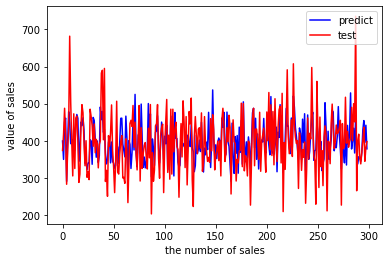

In [113]:
sum_mean=0
for i in range(len(y_pred)):
    sum_mean+=(y_pred[i]-y_test[i])**2
sum_erro=np.sqrt(sum_mean/10)  #这个10是你测试级的数量
    # calculate RMSE by hand
print ("RMSE by hand:",sum_erro)
    #做ROC曲线
plt.figure()
plt.plot(range(len(y_pred)),y_pred,'b',label="predict")
plt.plot(range(len(y_pred)),y_test,'r',label="test")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of sales")
plt.ylabel('value of sales')
plt.show()

In [114]:
score = model.score(X_test, y_test)
score

0.3612579232207557

## Random Forest

In [115]:
import pandas as pd
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
import multiprocessing
from multiprocessing import Process,Queue,Pool
from sklearn.ensemble import RandomForestRegressor

In [116]:
# 因变量：汽油消耗量
X = dataset.iloc[:, 1:3].values
y = dataset.iloc[:, 0].values

# 将数据分为训练集和测试集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [117]:
# 训练随机森林解决回归问题
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=240)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
random_forest_error=y_pred-y_test

RMSE by hand: 253.47041647141916


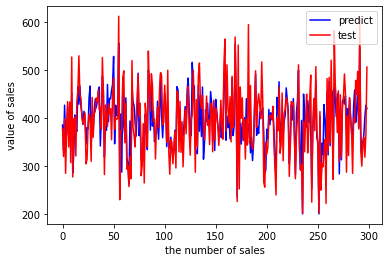

In [118]:
sum_mean=0
for i in range(len(y_pred)):
    sum_mean+=(y_pred[i]-y_test[i])**2
sum_erro=np.sqrt(sum_mean/10)  #这个10是你测试级的数量
    # calculate RMSE by hand
print ("RMSE by hand:",sum_erro)
    #做ROC曲线
plt.figure()
plt.plot(range(len(y_pred)),y_pred,'b',label="predict")
plt.plot(range(len(y_pred)),y_test,'r',label="test")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of sales")
plt.ylabel('value of sales')
plt.show()

In [ ]:
from pickle import TRUE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
param_grid = [
    # 尝试 12 (3×4) 的超参数组合
    {'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]},
    # 在bootstrap设置为False的情况下，尝试6 (2×3) 的超参数组合
    ]

forest_reg = RandomForestRegressor(random_state=42)
# 尝试5折交叉验证, 总共进行了(12+6)*5=90训练 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
# 数据集是来自房价预测
grid_search.fit(X_train, y_train)

In [ ]:
from pickle import TRUE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
param_grid = [
    # 尝试 12 (3×4) 的超参数组合
    {
     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]},
    # 在bootstrap设置为False的情况下，尝试6 (2×3) 的超参数组合
    ]

forest_reg = RandomForestRegressor(random_state=42)
# 尝试5折交叉验证, 总共进行了(12+6)*5=90训练 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
# 数据集是来自房价预测
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_ 

NameError: name 'grid_search' is not defined

In [33]:
from sklearn import metrics
import numpy as np

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:',
      np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 33.81685857482393
Mean Squared Error: 2138.4594748226255
Root Mean Squared Error: 46.24348034937061


In [119]:
score = regressor.score(X_test, y_test)
score

0.6029865094530878

## rate

In [98]:
pre_23 = pt.iloc[0:166, 0:2].values
pre_24 = pt.iloc[166:332, 0:2].values
pre_25 = pt.iloc[332:498, 0:2].values


In [99]:
from pandas import DataFrame
import csv
pre_23 = {'postcode': pt.iloc[0:166].index, 'rent': regressor.predict(pre_23)}
pre_23 = DataFrame(pre_23)

pre_24 = {'postcode': pt.iloc[166:332].index, 'rent': regressor.predict(pre_24)}
pre_24 = DataFrame(pre_24)

pre_25 = {'postcode': pt.iloc[332:498].index, 'rent': regressor.predict(pre_25)}
pre_25 = DataFrame(pre_25)


In [72]:
df_23 = df.iloc[0:166]
df_24 = df.iloc[166:332]
df_25 = df.iloc[332:498]



In [58]:
df_22 = df3.drop(df3.columns[1:9], axis=1)
df_22

,postcode,2022
0,3206,510.0
1,3206,510.0
2,3182,510.0
3,3143,440.0
4,3054,587.5
...,...,...
222,3844,370.0
223,3677,375.0
224,3820,400.0
225,3280,400.0


In [85]:
result_23 = pd.merge(df_23, df_22, how='left', on='postcode')

In [86]:
result_24 = pd.merge(df_24, df_22, how='left', on='postcode')

In [87]:
result_25 = pd.merge(df_25, df_22, how='left', on='postcode')

In [88]:
sub = df2.drop(df2.columns[1:35], axis=1)
sub1 = sub.drop(sub.columns[2:], axis=1)
sub1

,suburb,postcode
0,Albert Park,3206
1,Middle Park,3206
2,West St Kilda,3182
3,Armadale,3143
4,Carlton North,3054
...,...,...
222,Traralgon,3844
223,Wanagaratta,3677
224,Warragul,3820
225,Warrnambool,3280


In [89]:
result_23['rate'] = (result_23['rent']-result_23['2022'])/result_23['2022']
result_24['rate'] = (result_24['rent']-result_24['2022'])/result_24['2022']
result_25['rate'] = (result_25['rent']-result_25['2022'])/result_25['2022']

In [90]:
suburb_23 = pd.merge(sub1, result_23, how='inner', on='postcode')
suburb_24 = pd.merge(sub1, result_24, how='inner', on='postcode')
suburb_25 = pd.merge(sub1, result_25, how='inner', on='postcode')


In [91]:
suburb_23 = suburb_23.drop_duplicates(subset='suburb',keep='first')
suburb_24 = suburb_24.drop_duplicates(subset='suburb',keep='first')
suburb_25 = suburb_25.drop_duplicates(subset='suburb',keep='first')


In [92]:
suburb_23.sort_values(by='rate',ascending=False).head(10)

,suburb,postcode,rent,2022,rate
179,Moonee Ponds,3039,585.229167,416.5,0.405112
110,Carnegie,3163,540.827431,392.5,0.377904
114,Murrumbeena,3163,540.827431,392.5,0.377904
67,Hawthorn,3122,484.765625,355.0,0.365537
118,Caulfield,3162,540.827431,405.0,0.335376
184,Greensborough,3088,551.056250,417.5,0.319895
270,Mount Clear,3350,461.887622,350.0,0.319679
261,Ballarat,3350,461.887622,350.0,0.319679
279,Alfredton,3350,461.887622,350.0,0.319679
11,Parkville,3052,412.388021,314.5,0.311250


In [93]:
suburb_24.sort_values(by='rate',ascending=False).head(10)

,suburb,postcode,rent,2022,rate
184,Greensborough,3088,674.486458,417.5,0.615536
384,Morwell,3840,437.870288,285.0,0.536387
374,Hamilton,3300,462.155990,310.0,0.490826
179,Moonee Ponds,3039,603.801042,416.5,0.449702
203,Heidelberg,3084,597.929167,422.5,0.415217
194,Montmorency,3094,674.486458,485.0,0.390694
147,Sydenham,3037,556.826302,405.0,0.374880
110,Carnegie,3163,528.197917,392.5,0.345727
114,Murrumbeena,3163,528.197917,392.5,0.345727
136,Melton,3337,470.715625,350.0,0.344902


In [94]:
suburb_25.sort_values(by='rate',ascending=False).head(10)

,suburb,postcode,rent,2022,rate
374,Hamilton,3300,507.041319,310.0,0.635617
184,Greensborough,3088,651.122917,417.5,0.559576
147,Sydenham,3037,625.824306,405.0,0.545245
11,Parkville,3052,477.074740,314.5,0.516931
182,Sunbury,3429,582.967708,395.0,0.475868
384,Morwell,3840,412.214583,285.0,0.446367
203,Heidelberg,3084,608.055208,422.5,0.439184
288,Buninyong,3357,520.908631,365.0,0.427147
67,Hawthorn,3122,506.010417,355.0,0.425381
126,Footscray,3011,515.343924,366.5,0.406123
